In [1]:
import importlib
import ETDataInterface as et
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

importlib.reload(et)

<module 'ETDataInterface' from 'c:\\Users\\joste\\Personal\\Uni\\9_Semester\\TTK4550_Fordypningsprosjekt\\Code\\Notebooks\\ETDataInterface.py'>

## Dataset load and pre processing

In [2]:
interface = et.ETDataInterface()
dataset = interface.GetDataset(["FIXATION", "SACCADE"])

In [3]:
plotInterface = et.ETDataInterface(False)
plotDataset = plotInterface.GetDataset()

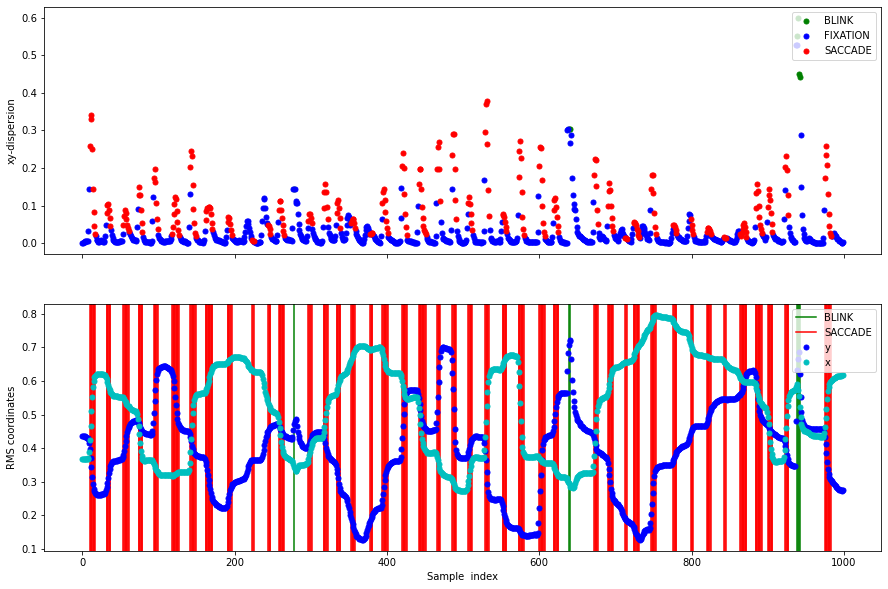

In [4]:
def plotDatasetQuality(df):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex='col')
    fig.set_figheight(10)
    fig.set_figwidth(15)
    groups = df.groupby("Label")
    colorMap = {"FIXATION": 'b', "SACCADE": 'r', "BLINK": 'g'}
    for name, group in groups:
        ax1.plot(group.index, group.disp, 
            marker='o', linestyle='', markersize=5, label=name, c=colorMap[name])
        if name == "SACCADE":
            it = 0
            for x in group.index:
                if it == 0:
                    ax2.axvline(x=x, c='r', label="SACCADE")
                    it = 1
                else: ax2.axvline(x=x, c='r')
        if name == "BLINK":
            it = 0
            for x in group.index:
                if it == 0:
                    ax2.axvline(x=x, c='g', label="BLINK")
                    it = 1
                else: ax2.axvline(x=x, c='g')

    ax2.plot(df.index, df.y_rms, 
        marker='o', linestyle='', markersize=5, label="y", c='b')
    ax2.plot(df.index, df.x_rms, 
        marker='o', linestyle='', markersize=5, label="x", c='c')
    ax2.set_xlabel('Sample  index')
    ax1.set_ylabel('xy-dispersion')
    ax2.set_ylabel('RMS coordinates')
    # ax1.set_title("Dataset Quality")
    ax1.legend(loc='upper right')
    ax2.legend(loc='upper right')\

%matplotlib inline
# plotDatasetQuality(plotDataset[7000:8000])
plotDatasetQuality(plotDataset[0:1000])


In [5]:
dataset["Label"] = dataset["Label"].replace({"FIXATION": 0, "SACCADE": 1})
dataset = dataset.drop(["Timestamp", "x", "y"], axis=1)

# Sum of target values
train_target_sums = dataset["Label"].value_counts()

In [6]:
# Split dataset into train and validation splits
train, test, y_train, y_test = train_test_split(dataset.drop(["Label"], axis="columns"),
        dataset["Label"], test_size=0.2)

## Create model and measure performance

In [7]:
%matplotlib inline
def PlotModelAUC(clf):
    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, clf.predict_proba(test)[:, 1])
    roc_auc = auc(fpr, tpr)

    # Plot
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
            lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title("Classifier performance measure")
    plt.legend(loc="lower right")
    plt.show()    

def PlotModelThresholds(clf):
    # Compute ROC curve and ROC area
    _, tpr, thresh = roc_curve(y_test, clf.predict_proba(test)[:, 1])

    # Plot
    plt.figure()
    lw = 2
    plt.plot(thresh, tpr, color='darkorange', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Labelling threshold')
    plt.ylabel('True Positive Rate')
    plt.title("Classifier Thresholds")
    plt.show()    

def PlotFeatureImportances(clf):
    clfFeatures = clf.feature_names_in_
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [clfFeatures[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

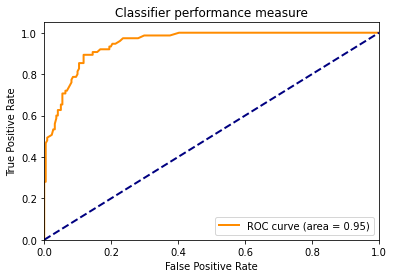

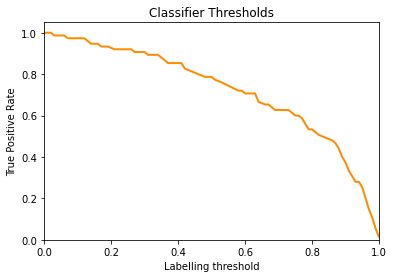

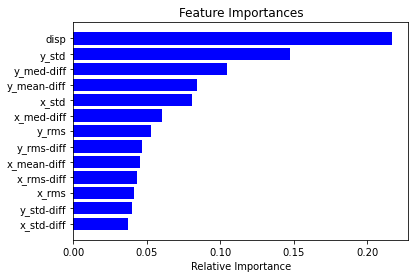

In [8]:
clf = RandomForestClassifier(
    n_jobs=-1,
    class_weight="balanced",
    criterion="entropy"
    )
clf.fit(train, y_train)

PlotModelAUC(clf)
PlotModelThresholds(clf)
PlotFeatureImportances(clf)

# clf = GradientBoostingClassifier()
# clf.fit(train, y_train)

# PlotModelAUC(clf, "GradientBoostingClassifier")

In [9]:
fpr, tpr, thresholds = roc_curve(y_test, clf.predict_proba(test)[:, 1])

best_thresh = 0
best_tpr = 0
best_ratio = 0
for i in range(len(thresholds)):
    if fpr[i] == 0 : continue
    if tpr[i]/fpr[i] > best_ratio:
        best_ratio = tpr[i]/fpr[i]
        best_thresh = thresholds[i]
        best_tpr = tpr[i]
        best_fpr = fpr[i]

predictions = clf.predict_proba(test)
prediction_results = pd.DataFrame({
    "y": y_test,
    "y_pred": predictions[:, 1] > best_thresh,
    "certainty": predictions[:, 1]
    })